# Considering serum cholesterol levels and resting blood pressure, is it likely for an individual to experience an exercise-induced angina?

# TODOs

* Improve exploratory visualization
* Improve analysis visualization
* Table / figure titles / numbers
* Discussion (what we find / whether it meets expected)

## Introduction

An angina is a common symptom of cardiovascular disease. It occurs when parts of the heart are not sufficiently supplied with oxygenated blood as a result of atherosclerosis (NHLBI, 2023). Atherosclerosis is the build-up of plaque in arteries usually caused by high levels of cholesterol that accumulate on artery walls, triggering an immune response. White blood cells attempt to clear the build-up but cling to the walls, forming a growing lump that permanently stays in place (Harvard Health, 2023). As a result, fewer red blood cells carrying oxygen are able to pass through the artery at once. Exercise-induced angina occurs as heart rate increases during exercise to supply more oxygen to the cells in need, inducing chest pain. The higher demand in oxygen and restricted supply due to the shrunken diameter of the artery leads to cardiac cell death (Heart and Stroke Canada). 

As a result, we strive for our model to predict the presence of an exercise induced angina for random individuals, taking into account their resting blood pressure as well as their cholesterol levels measured in dl / mg. 

**Question: Based on the predictors resting blood pressure and serum cholesterol levels, is the patient likely to experience exercise induced angina? How accurate is this prediction?**

**Dataset:** The heart disease dataset from Kaggle. The dataset itself provides variables correlating to cardiovascular health as well as classifications such as age and sex.

## Methods

The steps toward our result include:
1. Import the dataset into R using `read_csv()`.
2. Wrangle the dataframe by fixing column values for factors, using `mutate()`.
3. Numerically summarize the training dataset.
4. Visualize the training dataset.
5. Perform the data analysis using K-nearest-neighbors.
6. Visualize the data analysis using scattter plots.

### Import data into R and wrangle the data

Our dataset from Kaggle is pre-processed from a 1988 heart disease dataset (https://archive.ics.uci.edu/dataset/45/heart+disease) for easier data analysis and better readability. It has 17 variables related to cardiovascular health as well as basic information about the patients. It has 1025 rows of data. The definition of column names of the original dataset and the Kaggle dataset can be found on their respective websites.

In [1]:
# Load necessary libraries
library(tidyverse)
library(tidymodels)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1

In [2]:
# Download the CSV from our GitHub repository and parse it
heart_data_raw <- read_csv("https://raw.githubusercontent.com/L-Wendi/dsci-100-project/main/heart.csv")

glimpse(heart_data_raw)

Rows: 1025 Columns: 14
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 1,025
Columns: 14
$ age      <dbl> 52, 53, 70, 61, 62, 58, 58, 55, 46, 54, 71, 43, 34, 51, 52, 3…
$ sex      <dbl> 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1…
$ cp       <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 2, 0, 1, 2, 2…
$ trestbps <dbl> 125, 140, 145, 148, 138, 100, 114, 160, 120, 122, 112, 132, 1…
$ chol     <dbl> 212, 203, 174, 203, 294, 248, 318, 289, 249, 286, 149, 341, 2…
$ fbs      <dbl> 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0…
$ restecg  <dbl> 1, 0, 1, 1, 1, 0, 2, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0…
$ thalach  <dbl> 168, 155, 125, 161, 106, 122, 140, 145, 144, 116, 125, 136, 1…
$ exang    <dbl> 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0…
$ oldpeak  <dbl> 1.0, 3.1, 2.6, 0.0, 1.9, 1.0, 4.4, 0.8, 0.8, 3.2, 1.6, 3.0, 0…
$ slope    <dbl> 2, 0, 0, 2, 1, 1, 0, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 2, 2, 1…
$ ca       <dbl> 2, 0, 0, 1, 3, 0, 3, 1, 0, 2, 0, 0, 0, 3, 0, 0, 1, 1, 0, 0, 0…
$ thal     <dbl>

To answer our predictive question, we will use three columns:

1. `trestbps`: Resting blood pressure, measured in mm Hg (predictor).
2. `chol`: Serum cholesterol, in mg / dL (predictor).
3. `exang`: Exercise induced angina (target variable).

The original dataset has `exang` and a few other factor columns as `<dbl>` type. We wrangled the data, so these fields have meaningful `<fct>` types. To further clean the data, we only kept the relevant columns: `trestbps`, `chol`, and `exang`.

In [3]:
heart_data <- heart_data_raw |>
    mutate(sex = fct_recode(as_factor(sex), "Male" = "1", "Female" = "0")) |>
    mutate(exang = fct_recode(as_factor(exang), "Yes" = "1", "No" = "0")) |>
    mutate(target = fct_recode(as_factor(target), "No Disease" = "0", "Disease" = "1")) |>
    select(trestbps, chol, exang)

glimpse(heart_data)

Rows: 1,025
Columns: 3
$ trestbps <dbl> 125, 140, 145, 148, 138, 100, 114, 160, 120, 122, 112, 132, 1…
$ chol     <dbl> 212, 203, 174, 203, 294, 248, 318, 289, 249, 286, 149, 341, 2…
$ exang    <fct> No, Yes, Yes, No, No, No, No, Yes, No, Yes, No, Yes, No, Yes,…


### Exploratory data summarization

We did a summary of the predictors based on training data using the three columns of interest (`trestbps`, `chol`, and `exang`). Before doing the summary, we need to split the initial dataset into training set ($75\%$) and testing set ($25\%$), based on our target variable, `exang`. We will do our summarization based on the training dataset, because the testing dataset won't be used until the final prediction.

In [4]:
# Set the seed for every function requiring randomization to make it reproducible.
set.seed(1)

heart_split <- initial_split(heart_data, prop = 0.75, strata = exang)
heart_training <- training(heart_split)
heart_testing <- testing(heart_split)

nrow(heart_data)
glimpse(heart_training)
nrow(heart_testing)

[1] 1025

Rows: 768
Columns: 3
$ trestbps <dbl> 125, 148, 138, 100, 114, 120, 112, 118, 118, 120, 135, 120, 1…
$ chol     <dbl> 212, 203, 294, 248, 318, 249, 149, 210, 210, 244, 252, 209, 2…
$ exang    <fct> No, No, No, No, No, No, No, No, No, No, No, No, No, No, No, N…


[1] 257

After spliting the datasets, we can do the exploratory data summarization. We group the training data based on whether the patient has exercise induced angina (`exang`, the target variable), and then we summarize the min / mean / max values of both predictors.

In [5]:
heart_predictors_info <- heart_training |>
    select(exang, trestbps, chol) |>
    group_by(exang) |>
    summarize(count = n(),
              mean_trestbps = mean(trestbps), max_trestbps = max(trestbps), min_trestbps = min(trestbps),
              mean_chol = mean(chol), max_chol = max(chol), min_chol = min(chol))

heart_predictors_info

exang,count,mean_trestbps,max_trestbps,min_trestbps,mean_chol,max_chol,min_chol
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
No,510,130.9902,192,94,241.6255,564,126
Yes,258,132.3915,200,94,249.0039,409,131


### Exploratory data visualization

In the exploratory data analysis, we also drew a scatter plot based on training data to visualize the relationship between resting blood pressure and serum cholesterol, along with the presence of angina.

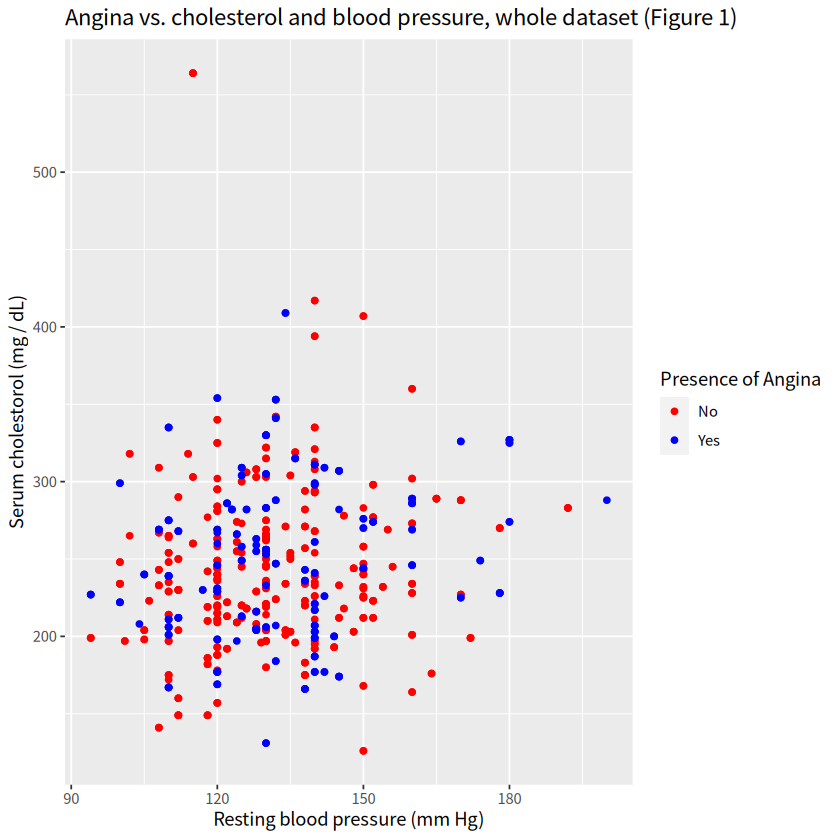

In [6]:
scatter_plot <- heart_training |> ggplot(aes(x = trestbps, y = chol, color = exang)) +
    geom_point() +
    labs(x = "Resting blood pressure (mm Hg)", y = "Serum cholestorol (mg / dL)", color = "Presence of Angina") +
    scale_color_manual(values = c("red", "blue")) +
    ggtitle("Angina vs. cholesterol and blood pressure, whole dataset (Figure 1)")
scatter_plot

### Data analysis

To answer our predictive question, we will be using K-nearest neighbors to build a classifier that predicts if the patient experiences exercise induced angina. The variables used as predictors are the resting blood pressure (`trestbps`) and serum cholesterol levels (`chol`). The response variable is the categorical variable for exercised induced angina (`exang`). This involves three steps:

1. Create a recipe to the training data.
2. Do a cross-validaation to figure out the optimal $K$ value.
3. Do the actual K-nearest-neighbors.
4. Collect metrics.

$title
[1] "Accuracy v.s. different K values (Figure 2)"

attr(,"class")
[1] "labels"

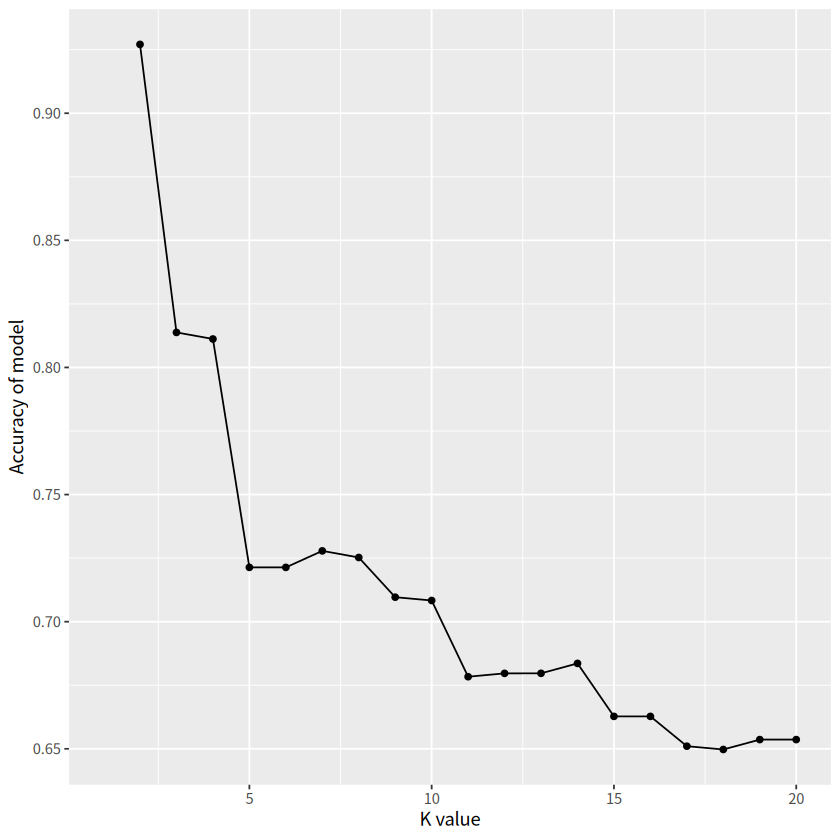

In [7]:
# Set the seed for every function requiring randomization to make it reproducible.
set.seed(2)

# 1. Create a recipe to standarize the training data.
heart_recipe <- recipe(exang ~ trestbps + chol, data = heart_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# 2.1: Create a KNN spec for cross-validation.
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")
# 2.2: Do cross-validation with five folds.
vfold <- vfold_cv(heart_training, v = 5, strata = exang)
# 2.3: Do cross-validation with K from 2 to 20.
gridvals <- tibble(neighbors = seq(from = 2, to = 20))
# 2.4: Exec the cross-validation and collect results.
wkflw <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = vfold, grid = gridvals) |>
    collect_metrics()
# 2.5: Plot the accuravy v.s. K line plot
results <- wkflw |>
    filter(.metric == "accuracy")
k_plot <- results |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "K value", y = "Accuracy of model") +
    xlim(1, 20)
    ggtitle("Accuracy v.s. different K values (Figure 2)")
k_plot

We picked $K = 3$ from the above graph because $K = 2$ would be overfitting, $K = 3$ is better than $K = 4$ in terms of accuracy, and $K = 3$ is odd which works well for our thing having only $2$ categories.

In [8]:
# Set the seed for every function requiring randomization to make it reproducible.
set.seed(3)

# 3.1: Create a KNN spec for final prediction
knn_3_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
    set_engine("kknn") |>
    set_mode("classification")

# 3.2: Train the final model using training data
heart_fit <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(knn_3_spec) |>
    fit(data = heart_training)

# 3.3: Do the prediction
heart_predictions <- predict(heart_fit, heart_testing) |>
    bind_cols(heart_testing)

glimpse(heart_predictions)

# 3.4: Collect metrics
heart_conf_mat <- heart_predictions |>
    conf_mat(truth = exang, estimate = .pred_class)

Rows: 257
Columns: 4
$ .pred_class <fct> Yes, No, Yes, Yes, No, No, Yes, Yes, Yes, No, No, No, No, …
$ trestbps    <dbl> 122, 140, 140, 140, 106, 136, 130, 160, 128, 160, 120, 120…
$ chol        <dbl> 286, 308, 211, 185, 223, 319, 131, 269, 263, 360, 258, 249…
$ exang       <fct> Yes, No, No, No, No, No, Yes, Yes, Yes, No, No, No, No, Ye…


Finally, collect the metrics of the prediction:

In [9]:
model_accuracy <- heart_predictions |>
    metrics(truth = exang, estimate = .pred_class) |>
    filter(.metric == "accuracy") |>
    pull(.estimate)

model_precision <- 66 / (14 + 66)
model_recall <- 66 / (21 + 66)

metrics <- tibble(accuracy = model_accuracy, precision = model_precision, recall = model_recall)

heart_conf_mat
metrics

          Truth
Prediction  No Yes
       No  156  21
       Yes  14  66

accuracy,precision,recall
<dbl>,<dbl>,<dbl>
0.8638132,0.825,0.7586207


### Visualize results

To effectively visualize the data analysis, we continued to plot the scatter diagram of predictors variables v.s. the predicted target variable. Readers can easily identify the two predicted categories.

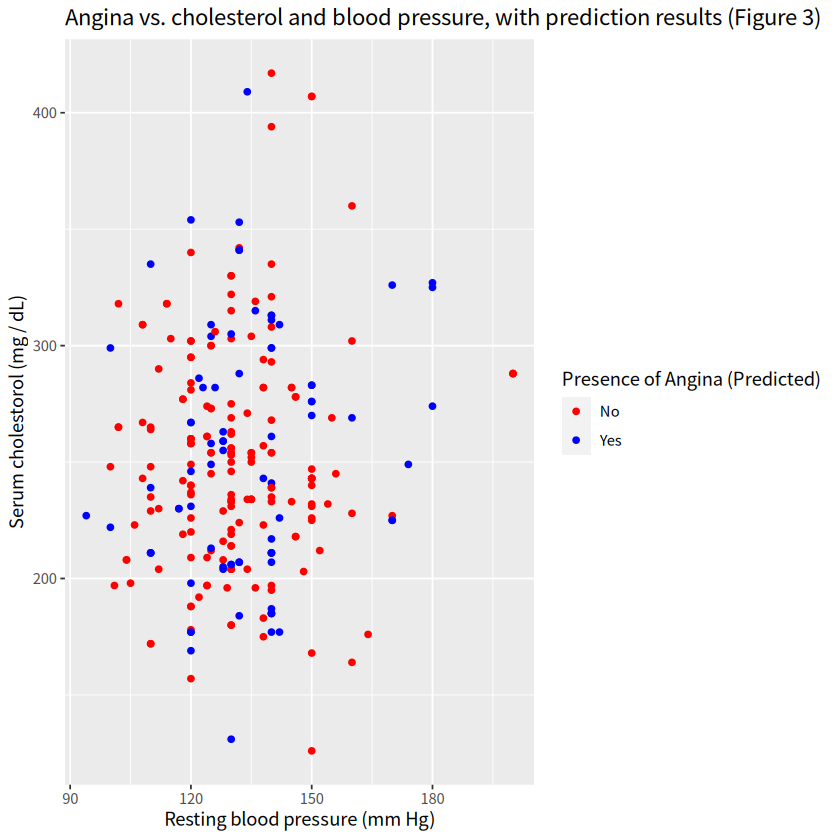

In [10]:
heart_predictions |> ggplot(aes(x = trestbps, y = chol, color = .pred_class)) +
    geom_point() +
    labs(x = "Resting blood pressure (mm Hg)", y = "Serum cholestorol (mg / dL)", color = "Presence of Angina (Predicted)") +
    scale_color_manual(values = c("red", "blue")) +
    ggtitle("Angina vs. cholesterol and blood pressure, with prediction results (Figure 3)")

In addition, in order to show the accuracy of our data analysis, we used different colors to indicate whether the prediction is correct or not, and we used different shapes to show the expected target variable (whether there is angina). We re-assigned colors to correctness and showed target variables using different shapes because colors are easier to identify than shapes, and correctness are more important than true values here.

Readers can easily identify the performance of the analysis.

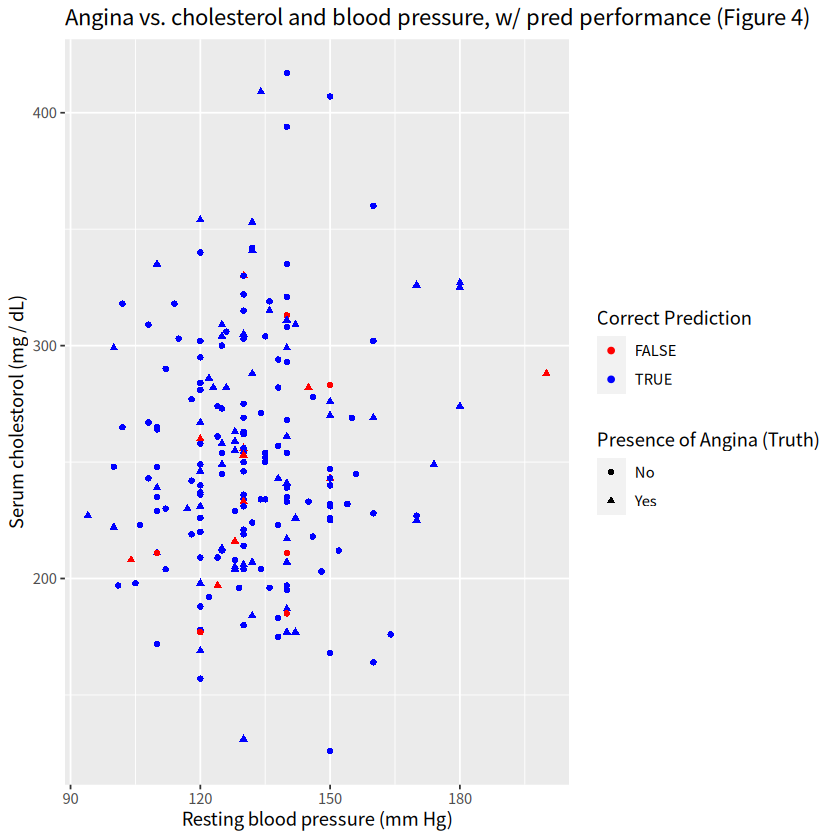

In [11]:
heart_predictions |> mutate(correct = .pred_class == exang) |>
    ggplot(aes(x = trestbps, y = chol, shape = exang, color = correct)) +
    geom_point() +
    labs(x = "Resting blood pressure (mm Hg)", y = "Serum cholestorol (mg / dL)", shape = "Presence of Angina (Truth)", color = "Correct Prediction") +
    scale_color_manual(values = c("red", "blue")) +
    ggtitle("Angina vs. cholesterol and blood pressure, w/ pred performance (Figure 4)")

## Discussion

### Findings

**TODO**

### Expectation

In our proposal, we expected to find:

> Seeing as how an angina occurs because of atherosclerosis we can predict that the cases of angina will increase as well when either variable increases.

**TODO**

### Impact

Being able to predict the likelihood of a patient getting an Angina is very important in the medical field as being able to catch heart disease early on is the best way of preventing future life threatening problems.

### Future Questions

We can test different variables in the model such as age, maximum heart rate, and resting heart rate can bring more insight into how this type of heart disease occurs.

## Bibliography

*Angina*, Heart and Stroke Foundation of Canada, 2023, www.heartandstroke.ca/heart-disease/conditions/angina.

*Angina: Symptoms, Diagnosis and Treatments*, Harvard Health Publishing, 21 Sept. 2021, www.health.harvard.edu/heart-health/angina-symptoms-diagnosis-and-treatments. 

*What Is Angina?*, U.S. Department of Health and Human Services, 23 June 2023, www.nhlbi.nih.gov/health/angina